In [1]:
import pandas as pd
import numpy as np


DATA CLEANING

In [2]:
df=pd.read_csv('education_augmented.csv')
print(df.head())
print(f"Number of rows : {len(df)}")

   Student_ID  Study_Hours Exam_Score
0           1          2.5         65
1           2          3.0         70
2           3          NaN         75
3           4         75.0         80
4           5          4.0         60
Number of rows : 300


In [3]:

# Convert Study_Hours to numeric, turning invalid entries into NaN
df['Study_Hours'] = pd.to_numeric(df['Study_Hours'], errors='coerce')
df['Exam_Score'] = pd.to_numeric(df['Exam_Score'], errors='coerce')
print(df.head(15))

    Student_ID  Study_Hours  Exam_Score
0            1          2.5        65.0
1            2          3.0        70.0
2            3          NaN        75.0
3            4         75.0        80.0
4            5          4.0        60.0
5            6          1.5        85.0
6            7          5.0        68.0
7            8          2.0        72.0
8            9          3.5        50.0
9           10         -1.0        90.0
10          11          6.0        55.0
11          12          NaN        78.0
12          13          4.5         NaN
13          14          2.0        70.0
14          15          3.0        -5.0


In [4]:

df_clean = df.dropna(subset=['Study_Hours', 'Exam_Score'])
print(f"Number of rows after dropping NaN: {len(df_clean)}")



Number of rows after dropping NaN: 297


In [5]:
# Fix negative Study_Hours by setting them to 0
df_clean['Study_Hours']=df_clean['Study_Hours'].apply(lambda x:max(x,0))
# Cap Exam_Score between 0 and 100
df_clean['Exam_Score'] = df_clean['Exam_Score'].apply(lambda x: max(0, min(x, 100)))
# Check summary statistics to see the cleaned data
print(df_clean.describe())


       Student_ID  Study_Hours  Exam_Score
count  297.000000   297.000000  297.000000
mean   151.925926     5.178249   74.663300
std     86.006096     5.008222   17.464668
min      1.000000     0.000000    0.000000
25%     78.000000     2.420000   62.000000
50%    152.000000     5.090000   77.000000
75%    226.000000     7.560000   89.000000
max    300.000000    75.000000  100.000000


C:\Users\Adio\AppData\Local\Temp\ipykernel_6216\1222032305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Study_Hours']=df_clean['Study_Hours'].apply(lambda x:max(x,0))
C:\Users\Adio\AppData\Local\Temp\ipykernel_6216\1222032305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Exam_Score'] = df_clean['Exam_Score'].apply(lambda x: max(0, min(x, 100)))


correlation coefficient

In [6]:
# Calculate the Pearson correlation coefficient
correlation=df_clean['Study_Hours'].corr(df_clean['Exam_Score'])

print(f"Correlation between Study Hours and Exam Score: {correlation:.2f}")

Correlation between Study Hours and Exam Score: 0.48


LINEAR REGRESSION MODEL
the slope too: how much the score increases per study hour
Intercept: The predicted score with 0 study hours.

In [7]:
from sklearn.linear_model import LinearRegression

# Prepare the data: X is the feature, y is the target
x=df_clean[['Study_Hours']]#
y=df_clean[['Exam_Score']]


model=LinearRegression()
model.fit(x,y)
slope = model.coef_[0].item()
intercept = model.intercept_.item()
# Calculate residuals
predicted_scores = model.predict(x)
residuals = y - predicted_scores
# Find the outlier
outlier_index = residuals.abs().idxmax().item()  # Extract the integer index

print(f"Potential outlier at index {outlier_index}: Study Hours = {df.loc[outlier_index, 'Study_Hours']}, Score = {df.loc[outlier_index, 'Exam_Score']}, Residual = {residuals.loc[outlier_index, 'Exam_Score']:.2f}")
print(f"Regression Equation: Exam_Score = {intercept:.2f} + {slope:.2f} * Study_Hours")


Potential outlier at index 3: Study Hours = 75.0, Score = 80.0, Residual = -111.01
Regression Equation: Exam_Score = 66.03 + 1.67 * Study_Hours


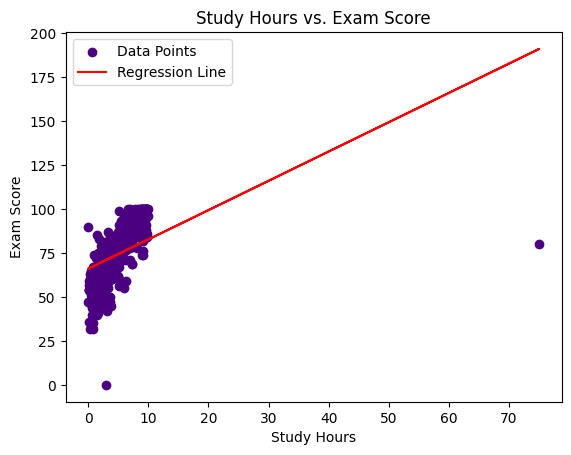

In [8]:
import matplotlib.pyplot as plt

# Update x to match df_clean after outlier removal
x_new = df_clean[['Study_Hours']]

# Scatter plot of data points
plt.scatter(df_clean['Study_Hours'], df_clean['Exam_Score'], color='indigo', label='Data Points')

# Regression line
plt.plot(df_clean['Study_Hours'], model.predict(x_new), color='red', label='Regression Line')

plt.xlabel('Study Hours')
plt.ylabel('Exam Score')
plt.title('Study Hours vs. Exam Score')
plt.legend()
plt.show()

R² to tells you how well the moodel explains the variation in Exam_Score



What This Does: R² ranges from 0 to 1. A value of 0.7 means 70% of the variation in scores is explained by study hours

In [9]:
r_squared = model.score(x, y)
print(f"R²: {r_squared:.2f}")

R²: 0.23


we have an outliner lets fix that lets use log scale 

Transform Study Hours

In [10]:
import numpy as np
df_clean['Log_Study_Hours'] = np.log(df_clean['Study_Hours'] + 1)

C:\Users\Adio\AppData\Local\Temp\ipykernel_6216\1608366632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Log_Study_Hours'] = np.log(df_clean['Study_Hours'] + 1)


it a New Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
x_log = df_clean[['Log_Study_Hours']]
y = df_clean['Exam_Score']
model_log = LinearRegression()
model_log.fit(x_log, y)
print(f"Regression Equation: Exam_Score = {model_log.intercept_:.2f} + {model_log.coef_[0]:.2f} * Log_Study_Hours")

Regression Equation: Exam_Score = 41.34 + 20.43 * Log_Study_Hours


In [12]:
r_squared_log = model_log.score(x_log, y)
print(f"New R²: {r_squared_log:.2f}")

New R²: 0.55


c:\Users\Adio\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


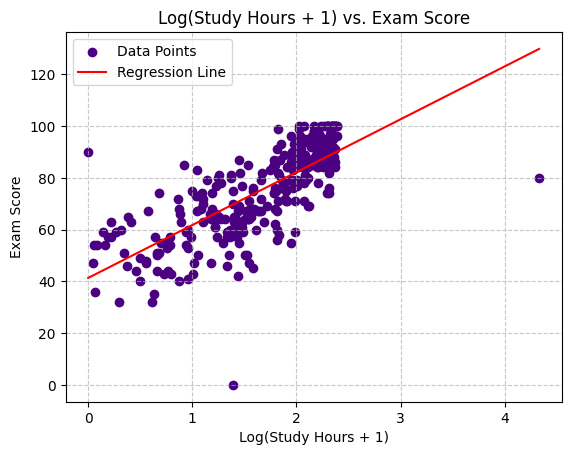

In [13]:
import matplotlib.pyplot as plt
x_range_log = np.linspace(0, df_clean['Log_Study_Hours'].max(), 100).reshape(-1, 1)
plt.scatter(df_clean['Log_Study_Hours'], df_clean['Exam_Score'], color='indigo', label='Data Points')
plt.plot(x_range_log, model_log.predict(x_range_log), color='red', label='Regression Line')
plt.xlabel('Log(Study Hours + 1)')
plt.ylabel('Exam Score')
plt.title('Log(Study Hours + 1) vs. Exam Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()                                                               

In [14]:
predicted_log = model_log.predict(x_log)
residuals_log = y - predicted_log
outlier_residual = residuals_log.loc[3]
print(f"New Residual for Outlier: {outlier_residual:.2f}")  

New Residual for Outlier: -49.80


remove index for outliner

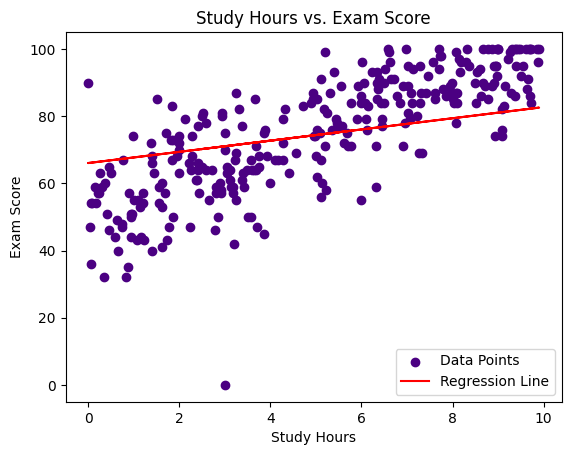

In [15]:

df_clean = df_clean.drop(index=3)


import matplotlib.pyplot as plt

# Update x to match df_clean after outlier removal
x_new = df_clean[['Study_Hours']]

# Scatter plot of data points
plt.scatter(df_clean['Study_Hours'], df_clean['Exam_Score'], color='indigo', label='Data Points')

# Regression line
plt.plot(df_clean['Study_Hours'], model.predict(x_new), color='red', label='Regression Line')

plt.xlabel('Study Hours')
plt.ylabel('Exam Score')
plt.title('Study Hours vs. Exam Score')
plt.legend()
plt.show()
